In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "C:/Users/LENOVO/Desktop/US  E-commerce records 2020.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')

df.columns = [col.strip().replace(" ", "_") for col in df.columns]

print(df.head())  # Display the first few rows of the DataFrame
print(df.columns)  # Display the column names of the DataFrame
print(df.info())  # Display information about the DataFrame 


  Order_Date  Row_ID        Order_ID       Ship_Mode Customer_ID      Segment  \
0   01-01-20     849  CA-2017-107503  Standard Class    GA-14725     Consumer   
1   01-01-20    4010  CA-2017-144463  Standard Class    SC-20725     Consumer   
2   01-01-20    6683  CA-2017-154466     First Class    DP-13390  Home Office   
3   01-01-20    8070  CA-2017-151750  Standard Class    JM-15250     Consumer   
4   01-01-20    8071  CA-2017-151750  Standard Class    JM-15250     Consumer   

         Country         City       State  Postal_Code   Region  \
0  United States       Lorain        Ohio        44052     East   
1  United States  Los Angeles  California        90036     West   
2  United States     Franklin   Wisconsin        53132  Central   
3  United States   Huntsville       Texas        77340  Central   
4  United States   Huntsville       Texas        77340  Central   

        Product_ID         Category Sub-Category  \
0  FUR-FU-10003878        Furniture  Furnishings   
1  FUR

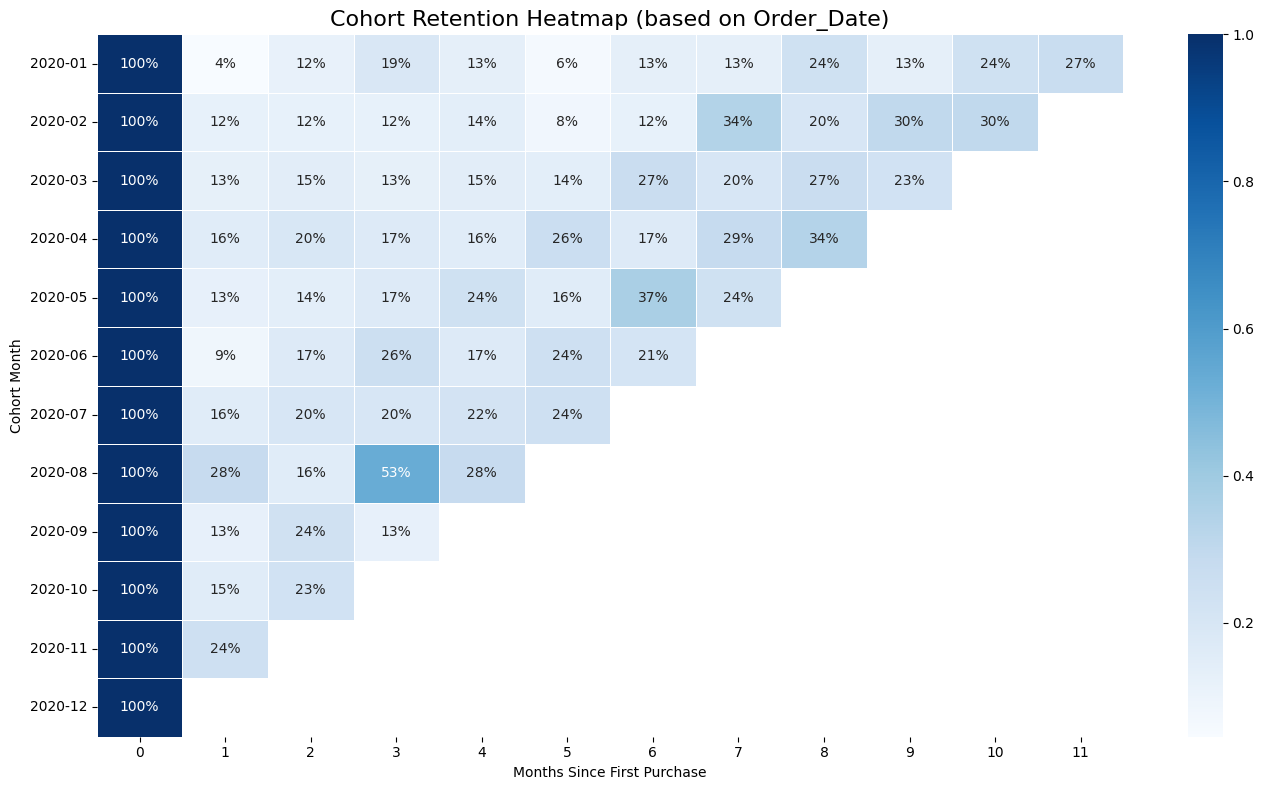

In [4]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%d-%m-%y')

# OrderMonth, CohortMonth 생성
df['OrderMonth'] = df['Order_Date'].dt.to_period('M')
df['CohortMonth'] = df.groupby('Customer_ID')['OrderMonth'].transform('min')

# CohortIndex 계산
def get_month_diff(row):
    return (row['OrderMonth'].year - row['CohortMonth'].year) * 12 + (row['OrderMonth'].month - row['CohortMonth'].month)

df['CohortIndex'] = df.apply(get_month_diff, axis=1)

# 코호트 피벗 테이블 생성
cohort_counts = df.groupby(['CohortMonth', 'CohortIndex'])['Customer_ID'].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index='CohortMonth', columns='CohortIndex', values='Customer_ID')

# 리텐션 테이블 생성
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0).round(3)

# 리텐션 히트맵 시각화
plt.figure(figsize=(14, 8))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues', linewidths=0.5)
plt.title('Cohort Retention Heatmap (based on Order_Date)', fontsize=16)
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.tight_layout()
plt.show()

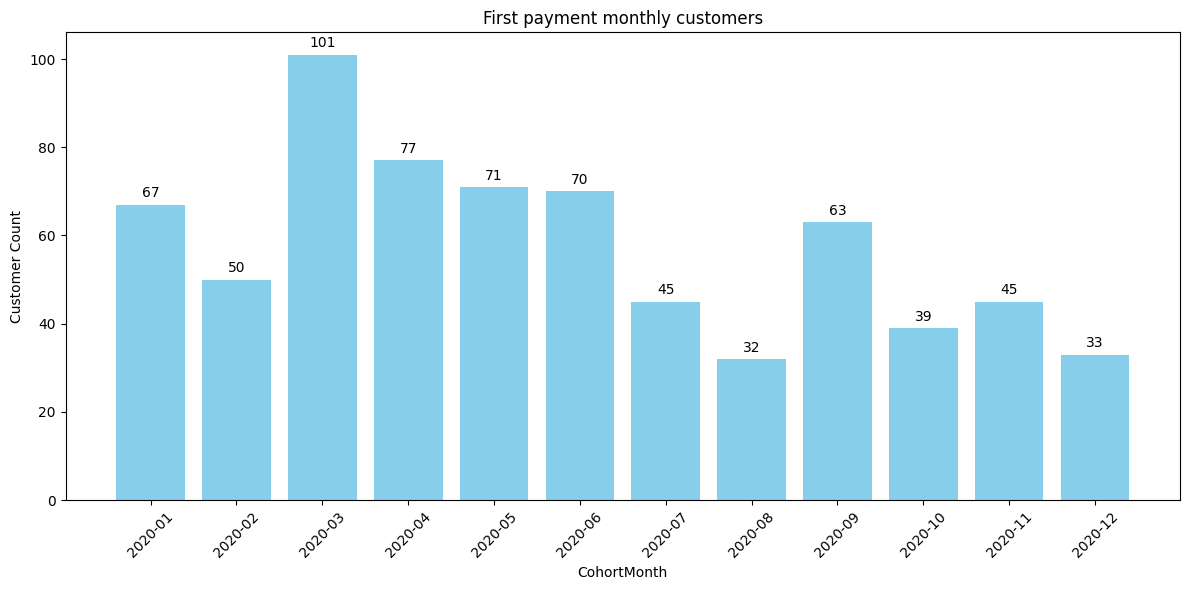

In [5]:
# month0 데이터 추출 (CohortIndex == 0인 고객 수)
month0_data = cohort_pivot.iloc[:, 0].reset_index()
month0_data.columns = ['CohortMonth', 'CustomerCount']

# 문자열로 바꿔서 보기 편하게
month0_data['CohortMonth'] = month0_data['CohortMonth'].astype(str)

# 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(month0_data['CohortMonth'], month0_data['CustomerCount'], color='skyblue')
plt.title("First payment monthly customers")
plt.xlabel("CohortMonth")
plt.ylabel("Customer Count")

# 막대 위에 숫자 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# Step 1: 고객별 주문일 정렬
purchase_intervals = df[["Customer_ID", "Order_Date"]].copy()
purchase_intervals.sort_values(by=["Customer_ID", "Order_Date"], inplace=True)

# Step 2: 각 고객의 이전 주문일과의 차이 계산
purchase_intervals["Prev_Order_Date"] = purchase_intervals.groupby("Customer_ID")["Order_Date"].shift(1)
purchase_intervals["Days_Between"] = (
    purchase_intervals["Order_Date"] - purchase_intervals["Prev_Order_Date"]
).dt.days

# Step 3: 고객별 평균 구매 주기 계산
purchase_cycle_stats = purchase_intervals.dropna().groupby("Customer_ID")["Days_Between"].mean().reset_index()
purchase_cycle_stats.columns = ["Customer_ID", "Avg_Purchase_Cycle"]

# 중앙값 계산
median_cycle = purchase_cycle_stats["Avg_Purchase_Cycle"].median()
print("중앙값 기준 구매 주기 (일):", round(median_cycle, 2))


중앙값 기준 구매 주기 (일): 28.25


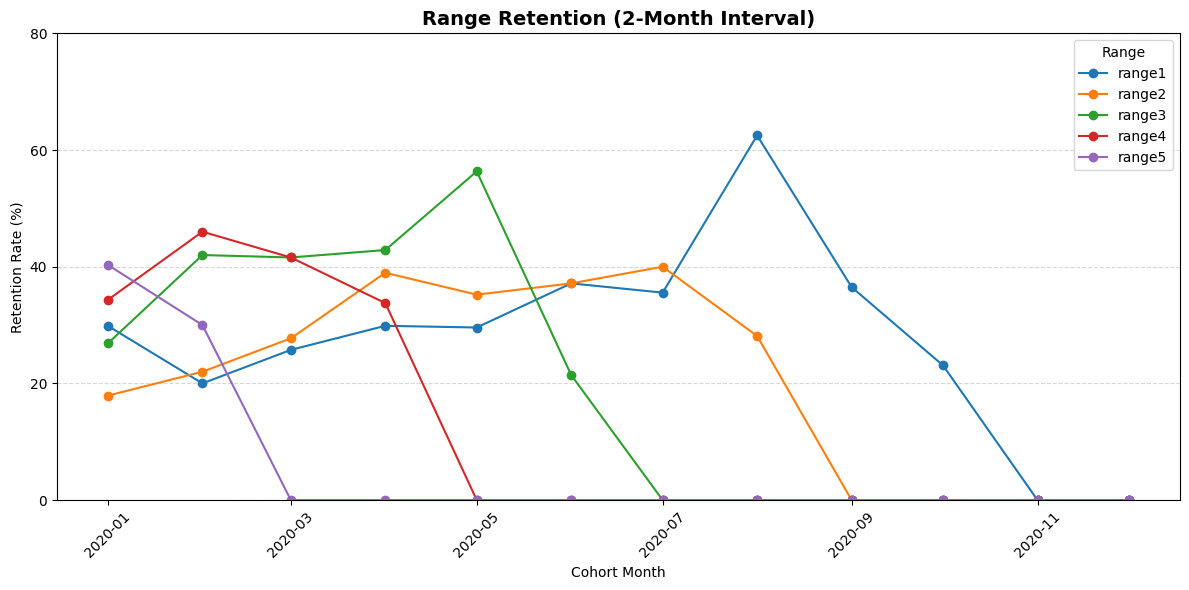

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 날짜 형식 정리
df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%d-%m-%y')
df['OrderMonth'] = df['Order_Date'].dt.to_period('M').dt.to_timestamp()

# 기존 CohortMonth가 있다면 삭제
if 'CohortMonth' in df.columns:
    df = df.drop(columns='CohortMonth')

# CohortMonth 생성
cohort_info = df.groupby('Customer_ID')['OrderMonth'].min().reset_index()
cohort_info.rename(columns={'OrderMonth': 'CohortMonth'}, inplace=True)
df = pd.merge(df, cohort_info, on='Customer_ID', how='left')

# 경과 개월 수 계산
df['MonthsFromFirst'] = (
    (df['OrderMonth'].dt.year - df['CohortMonth'].dt.year) * 12 +
    (df['OrderMonth'].dt.month - df['CohortMonth'].dt.month)
)

# 2개월 단위 Range 설정
df['Range_2m'] = (df['MonthsFromFirst'] // 2).astype(int)

# 고객 × 코호트 × Range 단위로 재구매 여부 계산
purchase_flags = df.groupby(['Customer_ID', 'CohortMonth', 'Range_2m'])['Order_ID'].nunique().reset_index()
purchase_flags['Retention'] = 1

# 첫 구매 Cohort 별 유니크 고객 수
cohort_sizes = purchase_flags[purchase_flags['Range_2m'] == 0].groupby('CohortMonth')['Customer_ID'].nunique()

# 각 Range별 유니크 고객 수
retention_counts = purchase_flags.groupby(['CohortMonth', 'Range_2m'])['Customer_ID'].nunique().unstack().fillna(0)

# Retention 비율 계산
retention_rate = retention_counts.divide(cohort_sizes, axis=0)
retention_rate = retention_rate.drop(columns=0)  # 첫 구매는 제외

# range0 제외하고 라벨링 변경
retention_rate.columns = [f'range{i}' for i in retention_rate.columns]

# 시각화
plt.figure(figsize=(12, 6))
for col in retention_rate.columns:
    plt.plot(retention_rate.index, retention_rate[col] * 100, marker='o', label=col)

plt.title("Range Retention (2-Month Interval)", fontsize=14, weight='bold')
plt.xlabel("Cohort Month")
plt.ylabel("Retention Rate (%)")
plt.xticks(rotation=45)
plt.ylim(0, 80)
plt.yticks(range(0, 81, 20))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Range')
plt.tight_layout()
plt.show()